# Discontinuity Analysis

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Show data without scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Kernel weighted RD

In [2]:
class Kernels:
    def __init__(self):
        pass
        

    # Triangular kernel
    def triangular_kernel(R, c, h):
        indicator = (np.abs(R - c) <= h).astype(float)
        return indicator * (1 - np.abs(R - c) / h)
    
    # Epanechnikov kernel
    def epanechnikov_kernel(R, c, h):
        indicator = (np.abs(R - c) <= h).astype(float)
        return indicator * (3/4) * (1 - ((R - c) / h) ** 2)
    

# Load the Data

In [3]:
# Load the data
df = pd.read_json('../data/creator_first_project.json', lines = True)
df.shape

(328652, 148)

In [4]:
# Print column names
print(df.columns.tolist())

['id', 'photo_key', 'photo_full', 'photo_ed', 'photo_med', 'photo_little', 'photo_small', 'photo_thumb', 'photo_1024x576', 'photo_1536x864', 'name', 'blurb', 'goal', 'pledged', 'state', 'slug', 'disable_communication', 'country', 'country_displayable_name', 'currency', 'currency_symbol', 'currency_trailing_code', 'deadline', 'state_changed_at', 'created_at', 'launched_at', 'staff_pick', 'is_starrable', 'backers_count', 'static_usd_rate', 'usd_pledged', 'converted_pledged_amount', 'fx_rate', 'usd_exchange_rate', 'current_currency', 'usd_type', 'creator_name', 'creator_slug', 'creator_is_registered', 'creator_is_email_verified', 'creator_chosen_currency', 'creator_is_superbacker', 'creator_avatar_thumb', 'creator_avatar_small', 'creator_avatar_medium', 'creator_urls_web_user', 'creator_urls_api_user', 'location_id', 'location_name', 'location_slug', 'location_short_name', 'location_displayable_name', 'location_localized_name', 'location_country', 'location_state', 'location_type', 'locat

In [5]:
# Calculate the dollars to goal
df['dollars_to_goal'] = df['pledged']  - df['goal']

# Key Statistics

In [6]:
# Check success next statistics
df[['goal', 'pledged', 'dollars_to_goal', 'staff_pick', 'backers_count']].describe()

,goal,pledged,dollars_to_goal,staff_pick,backers_count
count,3.286520e+05,3.286520e+05,3.286520e+05,321019.000000,328652.000000
mean,5.532205e+04,3.003814e+04,-2.528391e+04,0.114691,129.537985
std,2.102745e+06,1.318552e+06,2.368402e+06,0.318649,936.500952
min,1.000000e+00,0.000000e+00,-9.999999e+08,0.000000,0.000000
25%,2.000000e+03,7.500000e+01,-7.468000e+03,0.000000,3.000000
50%,5.000000e+03,1.260000e+03,-5.000000e+01,0.000000,21.000000
75%,1.500000e+04,6.383003e+03,6.441550e+02,0.000000,77.000000
max,1.000000e+09,4.816218e+08,4.278133e+08,1.000000,219382.000000


In [7]:
# Replace nas with 0
filled_df = df.copy()
filled_df = filled_df['success_next'].fillna(0)

In [8]:
cutoff = 0
bandwidth = 10000
bin_size = 20

# Filter out the outliers
plotting_df = df.copy()
plotting_df = plotting_df[(plotting_df['dollars_to_goal'] <= bandwidth) & (plotting_df['dollars_to_goal'] >= -bandwidth)]

# Split data into left and right of the cutoff
left_df = plotting_df[(plotting_df['state'] == 'failed') & (plotting_df['dollars_to_goal'] < cutoff)]
right_df = plotting_df[(plotting_df['state'] == 'successful') & (plotting_df['dollars_to_goal'] >= cutoff)]

# Bin each subset separately
left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)

# Aggregate the binned data for each subset
left_binned_data = left_df.groupby('dollars_to_goal_binned', observed=False).agg({
    'success_next': 'mean',
    'goal': 'mean',
    'backers_count': 'mean',
    'staff_pick': 'mean',
    'prelaunch_activated': 'mean',
    'dollars_to_goal': 'size'  # Counts the number of observations in each bin
}).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})
right_binned_data = right_df.groupby('dollars_to_goal_binned', observed=False).agg({
    'success_next': 'mean',
    'goal': 'mean',
    'backers_count': 'mean',
    'staff_pick': 'mean',
    'prelaunch_activated': 'mean',
    'dollars_to_goal': 'size'  # Counts the number of observations in each bin
}).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})

# Add a midpoint for each bin for both left and right data
left_binned_data['dollars_to_goal'] = left_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)
right_binned_data['dollars_to_goal'] = right_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)

# Combine the binned data for both sides of the cutoff
plotting_df = pd.concat([left_binned_data, right_binned_data], ignore_index=True)

C:\Users\d0tam\AppData\Local\Temp\ipykernel_32336\2535684319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_32336\2535684319.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)


In [9]:
# Describe success_next
plotting_df


,dollars_to_goal_binned,success_next,goal,backers_count,staff_pick,prelaunch_activated,n_obs,dollars_to_goal
0,"(-10010.0, -9500.01]",0.179229,10212.314541,4.749344,0.011394,0.075574,8382,-9755.005
1,"(-9500.01, -9000.02]",0.517241,10753.250555,20.224719,0.049592,0.144377,1513,-9250.015
2,"(-9000.02, -8500.03]",0.430464,10290.160231,19.818706,0.055701,0.138655,1561,-8750.025
3,"(-8500.03, -8000.04]",0.465347,10024.865697,23.227545,0.056818,0.147638,1169,-8250.035
4,"(-8000.04, -7500.05]",0.360190,8876.625504,13.722522,0.028438,0.107045,2411,-7750.045
5,"(-7500.05, -7000.06]",0.362573,8522.150250,15.950599,0.052442,0.096512,2004,-7250.055
6,"(-7000.06, -6500.07]",0.340782,7904.069253,15.307050,0.037371,0.119114,2397,-6750.065
7,"(-6500.07, -6000.08]",0.503546,7795.156622,20.009542,0.047837,0.119424,1572,-6250.075
8,"(-6000.08, -5500.09]",0.378151,6729.489352,12.724812,0.035588,0.105064,2918,-5750.085
9,"(-5500.09, -5000.1]",0.453552,6528.064023,18.187604,0.051793,0.122373,1807,-5250.095


## Plot Next Project Success by Dollars to Goal

Text(0.5, 1.0, 'Probability of Next Project Success by Dollars to Goal')

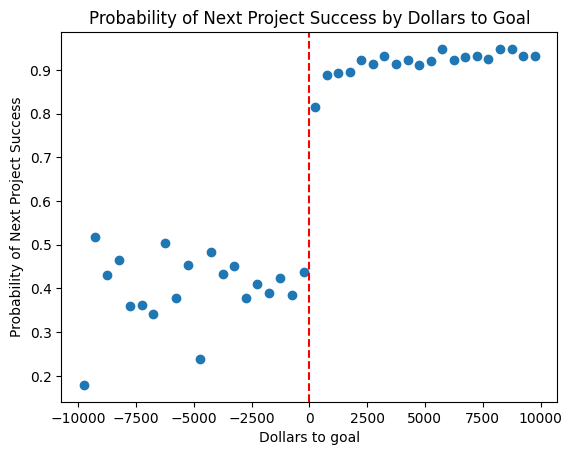

In [10]:
plt.figure()
plt.plot(plotting_df['dollars_to_goal'], plotting_df['success_next'], 'o')
plt.axvline(x=cutoff, color='r', linestyle='--')
plt.xlabel('Dollars to goal')
plt.ylabel('Probability of Next Project Success')
plt.title('Probability of Next Project Success by Dollars to Goal')

# Effect of First Kickstarter on Next Kickstarter

## Regression Variables

In [11]:
# Create threshold Variable
df = df.assign(threshold = (df['dollars_to_goal'] > 0).astype(int)).sort_values('dollars_to_goal').reset_index(drop=True)

# Calculate the dollars to goal times threshold
df['dollars_to_goal*threshold'] = np.abs(df['dollars_to_goal'] * df['threshold'])

## Naive Model

In [12]:
model = smf.logit('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold', df).fit()

model.summary().tables[1]


Optimization terminated successfully.
         Current function value: 0.449863
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.6389,0.017,-37.415,0.000,-0.672,-0.605
dollars_to_goal,5.618e-07,1.19e-07,4.716,0.000,3.28e-07,7.95e-07
threshold,2.6520,0.026,102.245,0.000,2.601,2.703
dollars_to_goal:threshold,3.987e-06,5.66e-07,7.039,0.000,2.88e-06,5.1e-06


Text(0.5, 1.0, 'Regression Discontinuity')

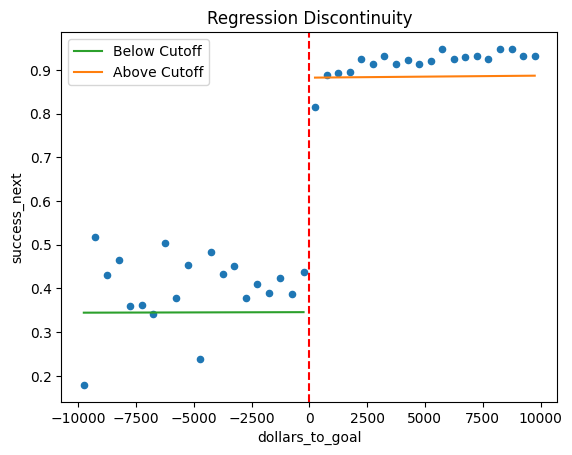

In [13]:
# Remove outliers
ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = {"dollars_to_goal": plotting_df['dollars_to_goal'].values, "threshold": plotting_df['threshold'].values, "dollars_to_goal:threshold": plotting_df['dollars_to_goal*threshold'].values}
plotting_df['predictions'] = model.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
left_plotting_df.plot(x = 'dollars_to_goal', y = 'predictions', color = 'C2', ax = ax, label = 'Below Cutoff')
right_plotting_df.plot(x = 'dollars_to_goal', y = 'predictions', color = 'C1', ax = ax, label = 'Above Cutoff')
ax.axvline(x = 1, color = 'red', linestyle = '--')
plt.title('Regression Discontinuity')

In [14]:
plotting_df

,dollars_to_goal_binned,success_next,goal,backers_count,staff_pick,prelaunch_activated,n_obs,dollars_to_goal,threshold,dollars_to_goal*threshold,predictions
0,"(-10010.0, -9500.01]",0.179229,10212.314541,4.749344,0.011394,0.075574,8382,-9755.005,0,-0.0,0.344266
1,"(-9500.01, -9000.02]",0.517241,10753.250555,20.224719,0.049592,0.144377,1513,-9250.015,0,-0.0,0.344330
2,"(-9000.02, -8500.03]",0.430464,10290.160231,19.818706,0.055701,0.138655,1561,-8750.025,0,-0.0,0.344394
3,"(-8500.03, -8000.04]",0.465347,10024.865697,23.227545,0.056818,0.147638,1169,-8250.035,0,-0.0,0.344457
4,"(-8000.04, -7500.05]",0.360190,8876.625504,13.722522,0.028438,0.107045,2411,-7750.045,0,-0.0,0.344521
5,"(-7500.05, -7000.06]",0.362573,8522.150250,15.950599,0.052442,0.096512,2004,-7250.055,0,-0.0,0.344584
6,"(-7000.06, -6500.07]",0.340782,7904.069253,15.307050,0.037371,0.119114,2397,-6750.065,0,-0.0,0.344648
7,"(-6500.07, -6000.08]",0.503546,7795.156622,20.009542,0.047837,0.119424,1572,-6250.075,0,-0.0,0.344711
8,"(-6000.08, -5500.09]",0.378151,6729.489352,12.724812,0.035588,0.105064,2918,-5750.085,0,-0.0,0.344775
9,"(-5500.09, -5000.1]",0.453552,6528.064023,18.187604,0.051793,0.122373,1807,-5250.095,0,-0.0,0.344838


## RD with Kernel

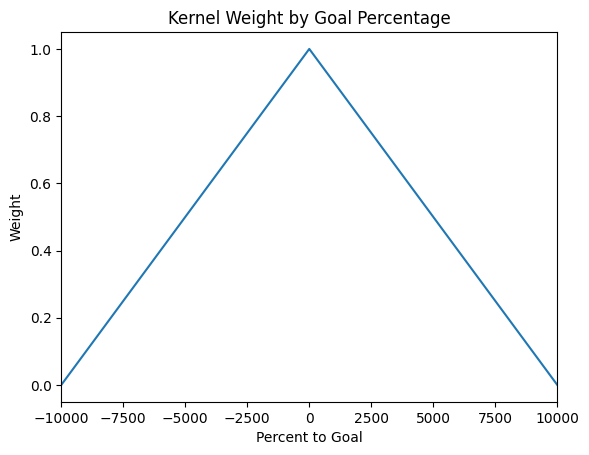

In [15]:
plt.plot(sorted(df["dollars_to_goal"]), Kernels.triangular_kernel(df["dollars_to_goal"], c=cutoff, h=bandwidth), label="Triangular Kernel")
plt.xlabel("Percent to Goal")
plt.ylabel("Weight")
plt.xlim(-bandwidth, bandwidth)
plt.title("Kernel Weight by Goal Percentage");

In [16]:
model1 = smf.wls('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold', df, weights = Kernels.triangular_kernel(R = df['dollars_to_goal'], c = cutoff, h = bandwidth)).fit()

model1.summary().tables[1]


c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:806: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4587,0.005,86.094,0.000,0.448,0.469
dollars_to_goal,1.93e-05,1.8e-06,10.718,0.000,1.58e-05,2.28e-05
threshold,0.3783,0.006,63.599,0.000,0.367,0.390
dollars_to_goal:threshold,3.472e-06,2.29e-06,1.517,0.129,-1.01e-06,7.96e-06


Text(0.5, 1.0, 'Regression Discontinuity')

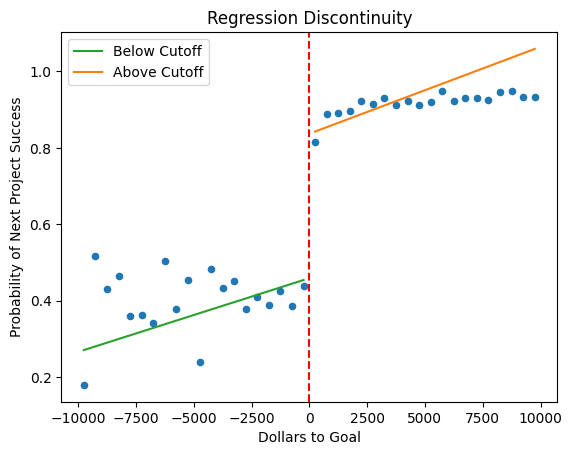

In [17]:
# Remove outliers
ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = {"dollars_to_goal": plotting_df['dollars_to_goal'].values, "threshold": plotting_df['threshold'].values, "dollars_to_goal:threshold": plotting_df['dollars_to_goal*threshold'].values}
plotting_df['predictions'] = model1.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
left_plotting_df.plot(x = 'dollars_to_goal', y = 'predictions', color = 'C2', ax = ax, label = 'Below Cutoff')
right_plotting_df.plot(x = 'dollars_to_goal', y = 'predictions', color = 'C1', ax = ax, label = 'Above Cutoff')
ax.axvline(x = 1, color = 'red', linestyle = '--')
plt.xlabel('Dollars to Goal')
plt.ylabel('Probability of Next Project Success')
plt.title('Regression Discontinuity')

## RD with Controls and Weights

In [ ]:
model = smf.wls('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold + goal + backers_count + staff_pick + prelaunch_activated + C(category_name)', df, weights = Kernels.triangular_kernel(R = df['dollars_to_goal'], c = cutoff, h = bandwidth)).fit()

model.summary().tables[1]


In [ ]:
# Remove outliers
ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = {"dollars_to_goal": plotting_df['dollars_to_goal'].values, 
             "threshold": plotting_df['threshold'].values, 
             "dollars_to_goal:threshold": plotting_df['dollars_to_goal*threshold'].values, 
             "goal": plotting_df['goal'].values,
             "backers_count": plotting_df['backers_count'].values,
             "staff_pick": plotting_df['staff_pick'].values,
             "prelaunch_activated": plotting_df['prelaunch_activated'].values}

plotting_df['predictions'] = model.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
left_plotting_df.plot(x = 'dollars_to_goal', y = 'predictions', color = 'C2', ax = ax, label = 'Below Cutoff')
right_plotting_df.plot(x = 'dollars_to_goal', y = 'predictions', color = 'C1', ax = ax, label = 'Above Cutoff')
ax.axvline(x = 1, color = 'red', linestyle = '--')
plt.xlabel('Dollars to Goal')
plt.ylabel('Probability of Next Project Success')
plt.title('Regression Discontinuity')

# CATE

## Conditional on Next Goal Intensity

Generate Intensity

In [51]:
# Create new column for ratio of new goal to first goal
df['new_goal/old_goal'] = df['usd_goal_next'] / df['usd_goal']

# Create new column for intensity where intensity is low if it new_goal/old_goal is between 0 and 0.5, medium low if it is between 0.5 and 0.75, same if it is between 0.75 and 1.25, and high if it is greater than 1.25 
df['intensity'] = 'low'
df.loc[(df['new_goal/old_goal'] >= 0.25) & (df['new_goal/old_goal'] < 0.5), 'intensity'] = 'medium low'
df.loc[(df['new_goal/old_goal'] >= 0.50) & (df['new_goal/old_goal'] < 0.75), 'intensity'] = 'medium'
df.loc[(df['new_goal/old_goal'] >= 0.75) & (df['new_goal/old_goal'] < 1), 'intensity'] = 'average'
df.loc[df['new_goal/old_goal'] == 1, 'intensity'] = 'same'
df.loc[(df['new_goal/old_goal'] > 1) & (df['new_goal/old_goal'] < 1.25), 'intensity'] = 'above average'
df.loc[(df['new_goal/old_goal'] >= 1.25) & (df['new_goal/old_goal'] < 1.5), 'intensity'] = 'high'
df.loc[(df['new_goal/old_goal'] >= 1.5) & (df['new_goal/old_goal'] < 2), 'intensity'] = 'very high'
df.loc[df['new_goal/old_goal'] >= 2, 'intensity'] = 'extremely high'



In [53]:
df['new_goal/old_goal'].describe()

count       45300.000
mean         2247.856
std        469866.890
min             0.000
25%             0.403
50%             0.995
75%             1.666
max     100000000.000
Name: new_goal/old_goal, dtype: float64

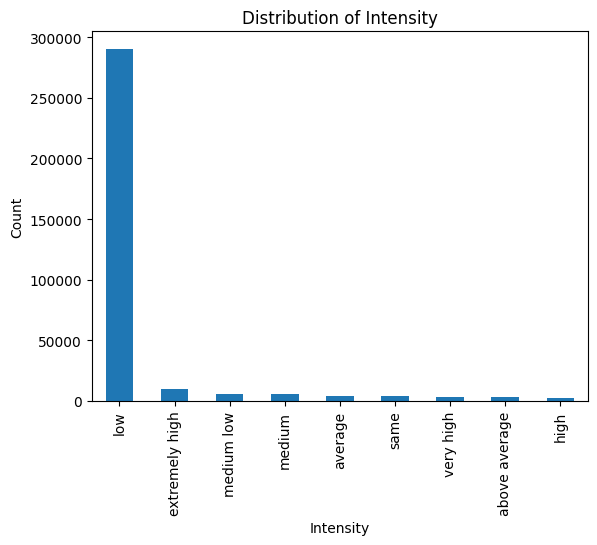

In [55]:
# Plot distribution of intensity
df['intensity'].value_counts().plot(kind = 'bar')
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Distribution of Intensity')
plt.show()

Optimization terminated successfully.
         Current function value: 0.534679
         Iterations 10
Intensity: low
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.1960      0.031     -6.422      0.000      -0.256      -0.136
dollars_to_goal            4.553e-07   1.18e-07      3.864      0.000    2.24e-07    6.86e-07
threshold                     2.9358      0.096     30.504      0.000       2.747       3.124
dollars_to_goal:threshold  2.936e-07   9.05e-07      0.325      0.746   -1.48e-06    2.07e-06


Optimization terminated successfully.
         Current function value: 0.493683
         Iterations 9
Intensity: medium low
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Inte

c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.306258
         Iterations 10
Intensity: same
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.6356      0.092     -6.880      0.000      -0.817      -0.455
dollars_to_goal            8.749e-05    1.3e-05      6.751      0.000    6.21e-05       0.000
threshold                     3.1540      0.123     25.551      0.000       2.912       3.396
dollars_to_goal:threshold -7.777e-05   1.33e-05     -5.832      0.000      -0.000   -5.16e-05


Optimization terminated successfully.
         Current function value: 0.330027
         Iterations 9
Intensity: above average
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------


C:\Users\d0tam\AppData\Local\Temp\ipykernel_32336\3053320243.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


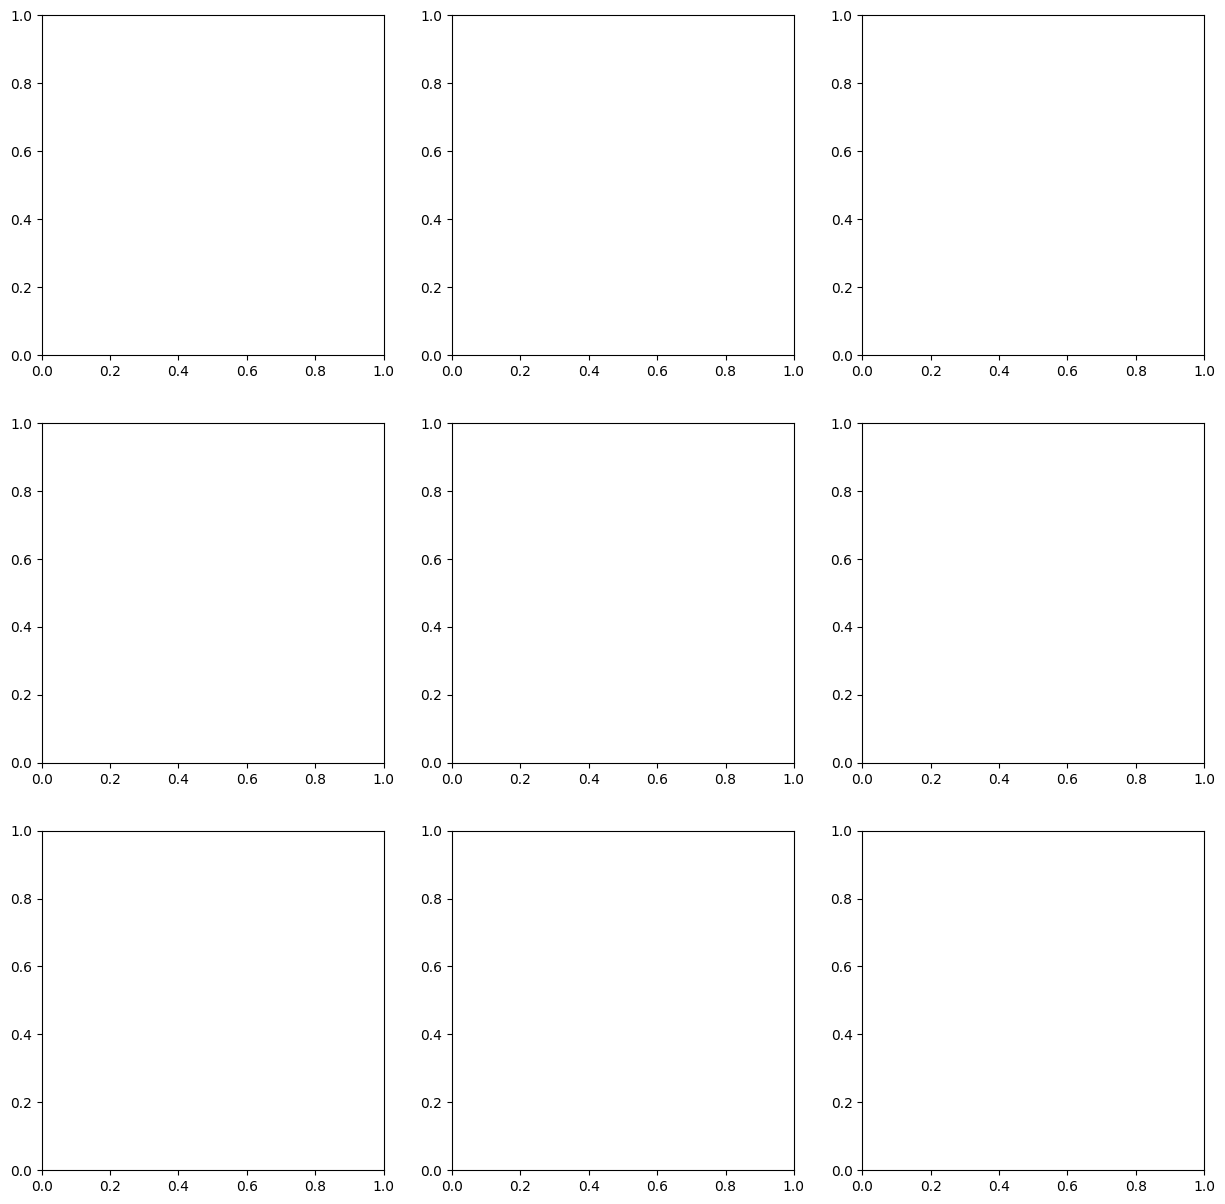

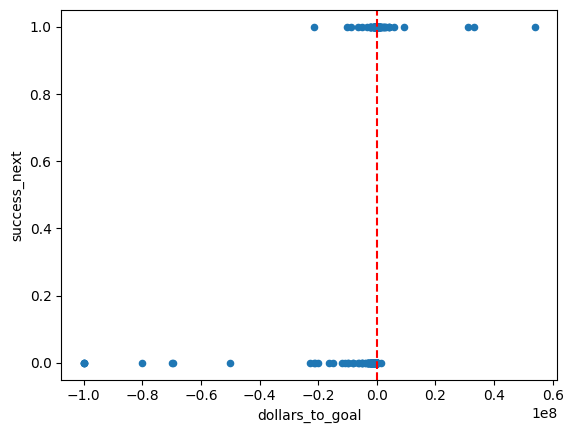

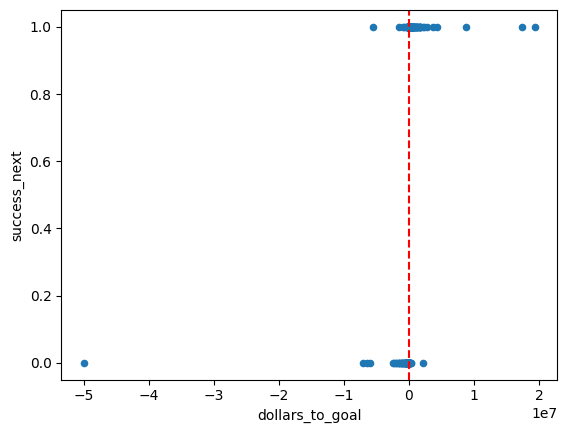

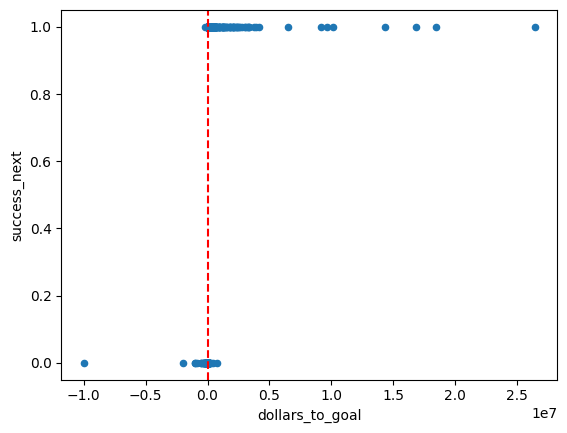

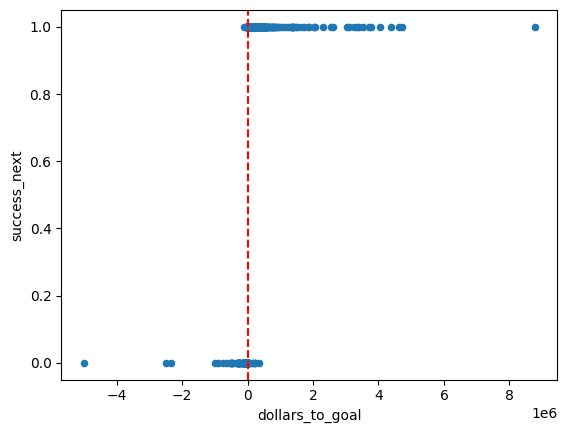

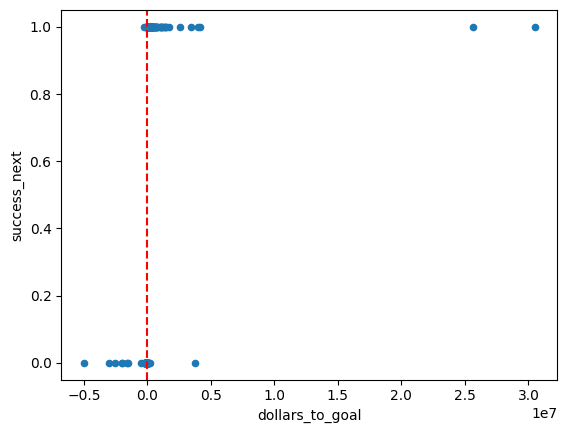

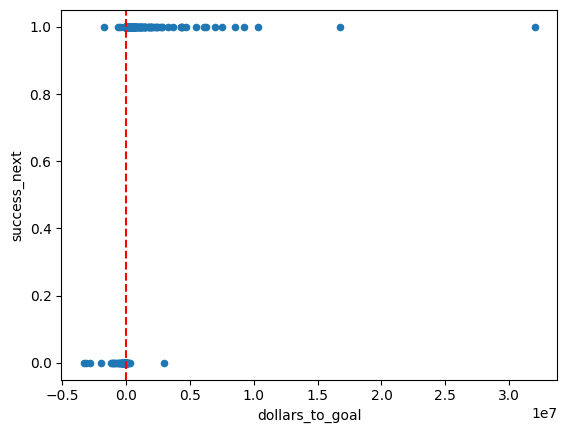

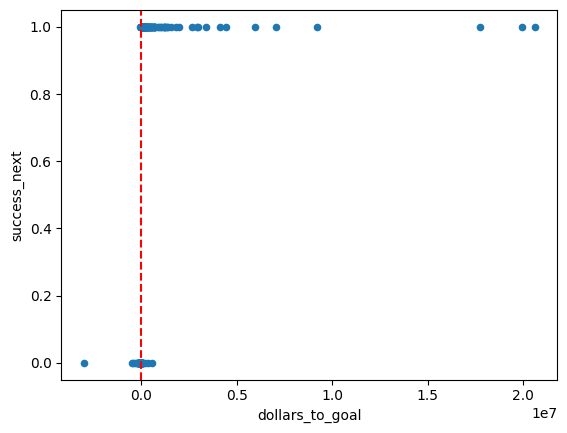

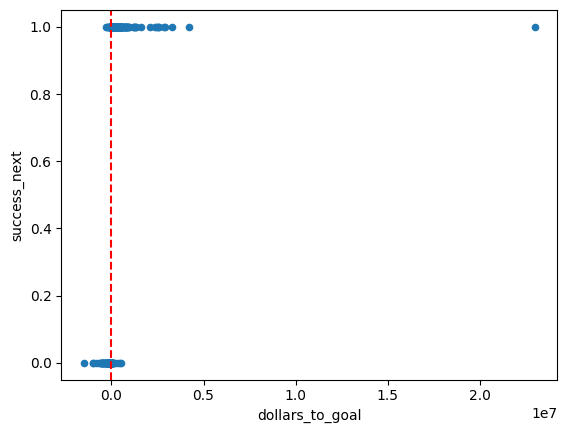

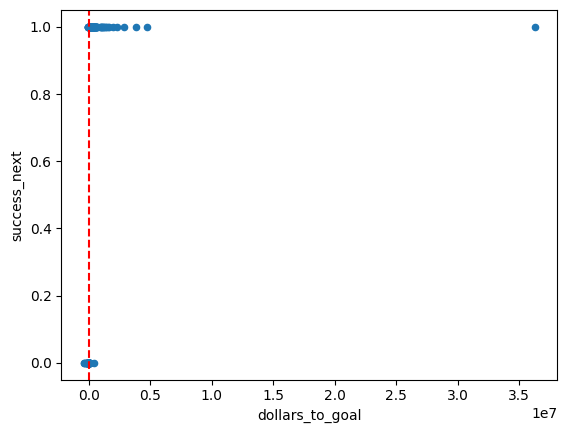

In [59]:
# Subplots for plotting
fig, axes = plt.subplots(3, 3, figsize = (15, 15))


for i in df['intensity'].unique():
    intensity_df = df[df['intensity'] == i]
    model = smf.logit('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold', intensity_df).fit()
    print(f"Intensity: {i}")
    print(model.summary().tables[1])
    print("\n")

    # Plot the regression discontinuity
    axes = intensity_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")
    axes.axvline(x = 0, color = 'red', linestyle = '--')

fig.show()